# Compute ImageNet Calibration Metrics

In [131]:
import blackhc.project.script

In [132]:
import torch
import numpy as np
from dataclasses import dataclass

In [133]:
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [134]:
@dataclass
class EnsembleLogitEvaluation:
  # BxNxC
  ensemble_logits: torch.Tensor
  # B
  labels: torch.Tensor

In [135]:
dataset_name = "imagenet"
val_probs_labels = !ls compute_results/{dataset_name}_val_probs*.pt
val_probs_labels

['compute_results/imagenet_val_probs_labels_beit_large_patch16_224.pt',
 'compute_results/imagenet_val_probs_labels_convnext_large_in22ft1k.pt',
 'compute_results/imagenet_val_probs_labels_deit3_large_patch16_224_in21ft1k.pt',
 'compute_results/imagenet_val_probs_labels_resnet152d.pt',
 'compute_results/imagenet_val_probs_labels_vit_base_patch16_384.pt']

In [35]:
def load_ensemble_probs_N_K_C(model_paths):
    probs = []
    labels = None
    for model_path in model_paths:
        prediction_info = torch.load(model_path)
        print("Loading:", prediction_info["pretrained_cfg"])
        new_labels = prediction_info["labels"]
        if labels is not None:
            assert torch.all(labels == new_labels)
        else:
            labels = new_labels
        probs += [prediction_info["predictions"]]
    probs = torch.stack(probs, dim=1)
    print("Loaded shape:", probs.shape)
    return probs, labels

In [36]:
ensemble_probs, dataset_labels = load_ensemble_probs_N_K_C(val_probs_labels)

Loading: {'url': 'https://conversationhub.blob.core.windows.net/beit-share-public/beit/beit_large_patch16_224_pt22k_ft22kto1k.pth', 'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None, 'crop_pct': 0.9, 'interpolation': 'bicubic', 'fixed_input_size': True, 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'first_conv': 'patch_embed.proj', 'classifier': 'head', 'architecture': 'beit_large_patch16_224'}
Loading: {'url': 'https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_1k_224.pth', 'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': (7, 7), 'crop_pct': 0.875, 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'first_conv': 'stem.0', 'classifier': 'head.fc', 'architecture': 'convnext_large_in22ft1k'}
Loading: {'url': 'https://dl.fbaipublicfiles.com/deit/deit_3_large_224_21k.pth', 'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None, 'crop_pct': 1.0, 'interpolation': 'bicubic', 'fixed_input_size': True,

In [ ]:
from scipy.special import digamma, polygamma
from scipy.optimize import minimize_scalar
import scipy.stats

In [99]:
def entropy(probs):
  """Compute the prediction entropy for each ensemble member separately."""
  nats = probs * torch.log(probs)
  nats[nats.isnan()]=0.
  return -nats.sum(dim=-1)

In [100]:
def ensemble_entropy(probs):
  """Compute the ensemble prediction entropy."""
  mean_probs = probs.mean(dim=1, keepdim=False)
  
  nats = mean_probs * mean_probs.log()
  nats[nats.isnan()]=0.
  entropy = -nats.sum(dim=-1)

  return entropy

In [101]:
def info_gain(logits):
  p_entropy = ensemble_entropy(logits)

  avg_softmax_entropies = entropy(logits).mean(dim=1,keepdim=False)

  value = p_entropy - avg_softmax_entropies
  return value


In [28]:
def probs_confidence_predictions(ensemble_probs):
  N, K, C = ensemble_probs.shape
  mean_probs = ensemble_probs.mean(dim=1, keepdim=False)

  confidences, predictions = torch.max(mean_probs, dim=-1)
  assert mean_probs.shape == (N, C)
  assert confidences.shape == (N,)
  assert predictions.shape == (N,)
  return mean_probs.numpy(), confidences.numpy(), predictions.numpy()

In [29]:
mean_probs, mean_confidences, mean_predictions = probs_confidence_predictions(ensemble_probs)

In [30]:
def top1_probs_confidence_predictions(ensemble_probs):
  N, K, C = ensemble_probs.shape
  one_hot_probs = torch.nn.functional.one_hot(torch.argmax(ensemble_probs, dim=-1), num_classes=C).float()
  mean_probs = one_hot_probs.mean(dim=1, keepdim=False)

  confidences, predictions = torch.max(mean_probs, dim=-1)
  assert mean_probs.shape == (N, C)
  assert confidences.shape == (N,)
  assert predictions.shape == (N,)
  return mean_probs.numpy(), confidences.numpy(), predictions.numpy()

In [31]:
top_probs, top_confidences, top_predictions = top1_probs_confidence_predictions(ensemble_probs)

# Compare Top1 and Normal Predictions and Probabilities

In [34]:
# How many predictions are different? Hopefully none?

(mean_predictions != top_predictions).sum() / len(mean_predictions)

# So about 2% :o

0.01898

In [38]:
print((mean_predictions == dataset_labels.numpy()).mean())
print((top_predictions == dataset_labels.numpy()).mean())

0.87912
0.87642


So the overall ensemble is about 0.003% better than using one-hot predictions! Which means the predictions between top and normal mostly disagree when they are wrong.

### Spike: Check that `torch.gather` and `np.take_along_axis` behave as expected

In [44]:
all(
  torch.gather(torch.as_tensor(top_probs), dim=1, index=dataset_labels.unsqueeze(1)).squeeze(1).numpy() 
    == 
  top_probs[range(len(dataset_labels)), dataset_labels.numpy()]
)

True

In [47]:
all(
  top_probs[range(len(dataset_labels)), dataset_labels.numpy()] 
    ==
  np.take_along_axis(top_probs, dataset_labels.numpy()[..., None], axis=-1).squeeze(-1)
)

True

# Compute Disagreement and Accuracy

In [49]:
def get_predicted_accuracy(probs):
  # E p(Y^ | x) = \sum p(Y^=c | x)^2
  N, C = probs.shape
  predicted_accuracy = (probs**2).sum(axis=-1)
  assert predicted_accuracy.shape == (N,)
  return predicted_accuracy

def get_predicted_error(probs):
  return 1 - get_predicted_accuracy(probs)

# TODO: remove these symbols?
get_agreement_rate = get_predicted_accuracy
get_disagreement_rate = get_predicted_error

def get_min_predicted_error(probs):
  return 1 - probs.max(axis=-1)

In [50]:
def get_true_predicted_probs(probs, labels):
  N, C = probs.shape
  assert labels.shape == (N,)
  true_predicted_probs = np.take_along_axis(probs, labels[..., None], axis=1).squeeze(1)
  assert true_predicted_probs.shape == (N,)
  return true_predicted_probs

# This is the expected accuracy, not the top1 accuracy!
get_accuracy = get_true_predicted_probs

# This is the expected error, not the top1 error!
def get_error(probs, labels):
  return 1 - get_accuracy(probs, labels)

In [51]:
get_true_predicted_probs(mean_probs, dataset_labels.numpy())

array([0.6478301 , 0.922449  , 0.8557156 , ..., 0.35579962, 0.00259598,
       0.59547734], dtype=float32)

# Compute Calibrations

In [52]:
labels = dataset_labels.numpy()

In [53]:
get_accuracy(mean_probs, labels).mean(), get_accuracy(top_probs, labels).mean()

(0.7621424, 0.85906804)

In [54]:
# from ddu_redux

def get_ece(predictions: np.ndarray, confidences: np.ndarray, labels: np.ndarray, *, num_bins: int):
    assert len(confidences) == len(predictions) == len(labels)

    accuracy = 1 * (predictions == labels)
    #print(accuracy.sum() / len(accuracy))

    bin_edges = np.histogram_bin_edges(confidences, bins=num_bins, range=[0, 1])
    bin_indices = np.digitize(confidences, bin_edges[:-1], right=False) - 1
    #print(bin_edges)
    #plt.hist(bin_indices, bins=num_bins)
    #plt.show()
    
    calibration_total_error = 0

    for bin_index in range(num_bins):
        bin_total_accuracy = np.sum(accuracy[bin_indices == bin_index])
        bin_total_confidence = np.sum(confidences[bin_indices == bin_index])
        #print(bin_total_accuracy, bin_total_confidence, sum(bin_indices == bin_index))

        calibration_total_error += np.abs(bin_total_accuracy - bin_total_confidence)

    calibration_error = calibration_total_error / len(labels)

    return calibration_error

In [56]:
get_ece(top_predictions, top_confidences, labels, num_bins=10), get_ece(mean_predictions, mean_confidences, labels, num_bins=10)

(0.0656760039138794, 0.06652825406312943)

In [57]:
def get_cace_jiang_paper(probs: np.ndarray, labels: np.ndarray, *, num_bins: int):
  # Following the appendix
  N, C = probs.shape
  assert labels.shape == (N,)

  bin_edges = np.histogram_bin_edges(probs, bins=num_bins, range=(0, 1))
  bin_indices = np.stack([np.digitize(probs[:, label], bin_edges[:-1], right=False) - 1 for label in range(C)], axis=-1)

  cace = 0
  for bin_index in range(num_bins):
    weights = (bin_indices == bin_index).sum() / N
    if not weights:
      continue
    q = probs[bin_indices == bin_index].mean()
    numerator_weights = sum(np.logical_and(bin_indices[:, label] == bin_index, labels == label) for label in range(C)).sum() / N
    cace += np.abs(numerator_weights / weights - q) * weights

  return cace

In [58]:
get_cace_jiang_paper(top_probs, labels, num_bins=10), get_cace_jiang_paper(mean_probs, labels, num_bins=10)

(0.15388001341760152, 0.14533282305411035)

In [67]:
def get_multi_ece(probs: np.ndarray, labels: np.ndarray, *, num_bins: int):
  N, C = probs.shape
  assert len(probs) == len(labels)

  mece = 0
    
  predictions = np.argmax(probs, axis=-1)

  for y in range(C):
    y_probs = probs[:, y]
    bin_edges = np.histogram_bin_edges(y_probs, bins=num_bins, range=[0, 1])
    bin_indices = np.digitize(y_probs, bin_edges[:-1], right=False) - 1
      
    for bin_index in range(num_bins):
      bin_mask = bin_indices == bin_index
      bin_accuracy = np.sum(y == labels[bin_mask])
      bin_confidence = np.sum(y_probs[bin_mask])
      
      mece += np.abs(bin_accuracy - bin_confidence)
      
  mece /= N
        
  return mece

In [68]:
import pandas as pd

In [109]:
def get_rejection_plot_rows(*, rejection_scores, max_score, num_bins, probs, labels):
  rejection_scores = rejection_scores.round(decimals=2) 
  confidences, predictions = torch.max(torch.as_tensor(probs), dim=-1)
  confidences = confidences.numpy()
  predictions = predictions.numpy()

  if max_score is None:
    max_score = rejection_scores.max()

  rows = []
  last_threshold = None
  last_indices = None
  for i, threshold in enumerate(np.linspace(0, max_score, num=num_bins, endpoint=True)):
    if i < num_bins - 1:
      indices = rejection_scores <= threshold
    else:
      indices = rejection_scores <= rejection_scores.max()*2
    # if last_threshold:
    #   indices = np.logical_and(indices, rejection_scores > last_threshold)
    # if not sum(indices):
    #   print(last_threshold, threshold, sum(indices))
    #   continue 
    # last_threshold = threshold

    print(threshold, sum(indices))

    indices = np.nonzero(indices)[0]
    #indices = np.random.choice(indices, size=7500)

    # if last_indices is not None:
    #   indices = np.concatenate([indices, last_indices])
    # last_indices = indices

    num_elements = len(indices)

    if not num_elements:
      continue
    
    mean_rejection_score = rejection_scores[indices].mean()
    max_rejection_score = rejection_scores[indices].max()

    bin_probs = probs[indices]
    bin_labels = labels[indices]

    predicted_error = get_predicted_error(bin_probs).mean()
    error = get_error(bin_probs, bin_labels).mean()
    calibration = np.abs(error - predicted_error)    
    ece = get_ece(predictions[indices], confidences[indices], bin_labels, num_bins=10)
    mece = get_multi_ece(bin_probs, bin_labels, num_bins=10)
    cace = get_cace_jiang_paper(bin_probs, bin_labels, num_bins=10)
   
    rows.append(dict(
        num_elements=num_elements,
        mean_rejection_score=mean_rejection_score, 
        max_rejection_score=max_rejection_score, 
        ece=ece,
        cace=cace,
        mece=mece,
        calibration=calibration,
        error=error,
        predicted_error=predicted_error,
    ))

  return rows

In [110]:
import seaborn as sns

In [111]:
get_disagreement_rate(mean_probs).max()

0.9912499

0.0 0
0.1414285727909633 18243
0.2828571455819266 32464
0.42428571837288986 37626
0.5657142911638532 42106
0.7071428639548165 46290
0.8485714367457797 48912
0.9900000095367432 50000


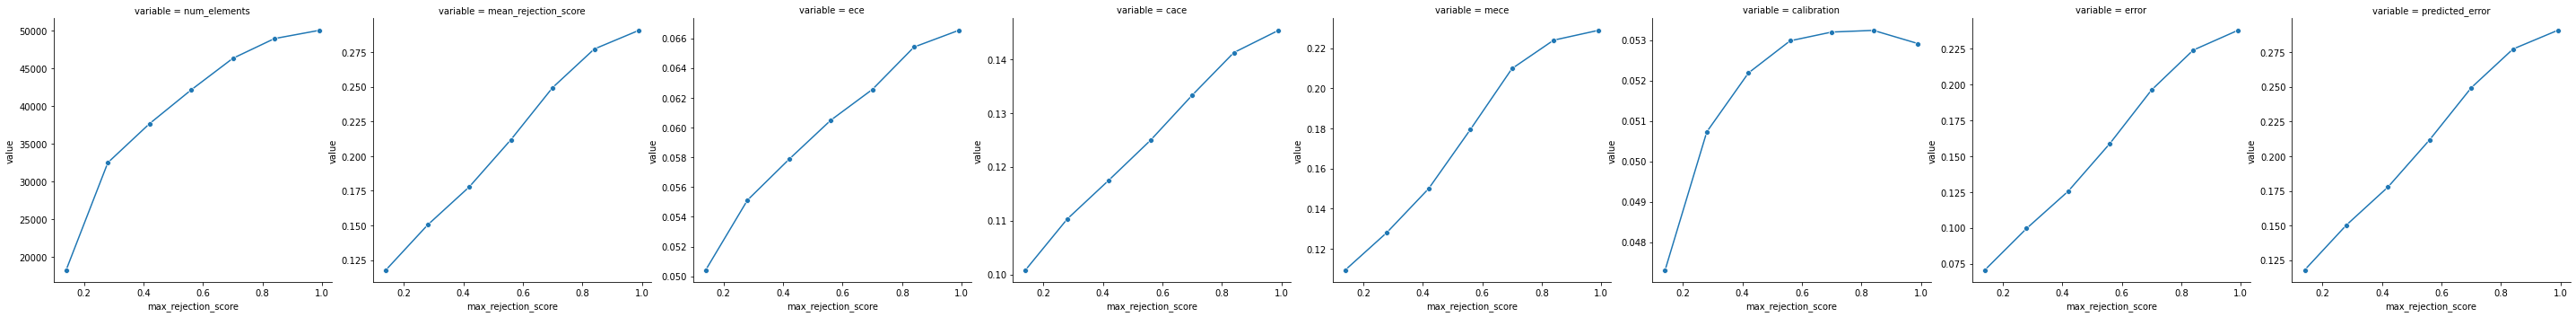

In [112]:
rows = get_rejection_plot_rows(rejection_scores=get_disagreement_rate(mean_probs),
                               max_score=None,
                               num_bins=8, 
                               probs=mean_probs,
                               labels=labels)

df=pd.DataFrame.from_dict(rows)
df.drop_duplicates(inplace=True)

dfm = pd.melt(df, id_vars="max_rejection_score")

sns.relplot(data=dfm, x="max_rejection_score", y="value", col="variable", marker="o", kind="line", aspect=1, facet_kws=dict(sharey=False))

df.to_csv(f"{dataset_name}_mean_disrate.csv", index=False)

In [127]:
rows = get_rejection_plot_rows(rejection_scores=info_gain(ensemble_probs).numpy(),
                               max_score=0.6,
                               num_bins=8, 
                               probs=mean_probs,
                               labels=labels)

df=pd.DataFrame.from_dict(rows)
df.drop_duplicates(inplace=True)

df.to_csv(f"{dataset_name}_mean_infogain.csv", index=False)



0.0 0
0.08571428571428572 35715
0.17142857142857143 41981
0.2571428571428571 44892
0.34285714285714286 47243
0.4285714285714286 48602
0.5142857142857142 49413
0.6 50000


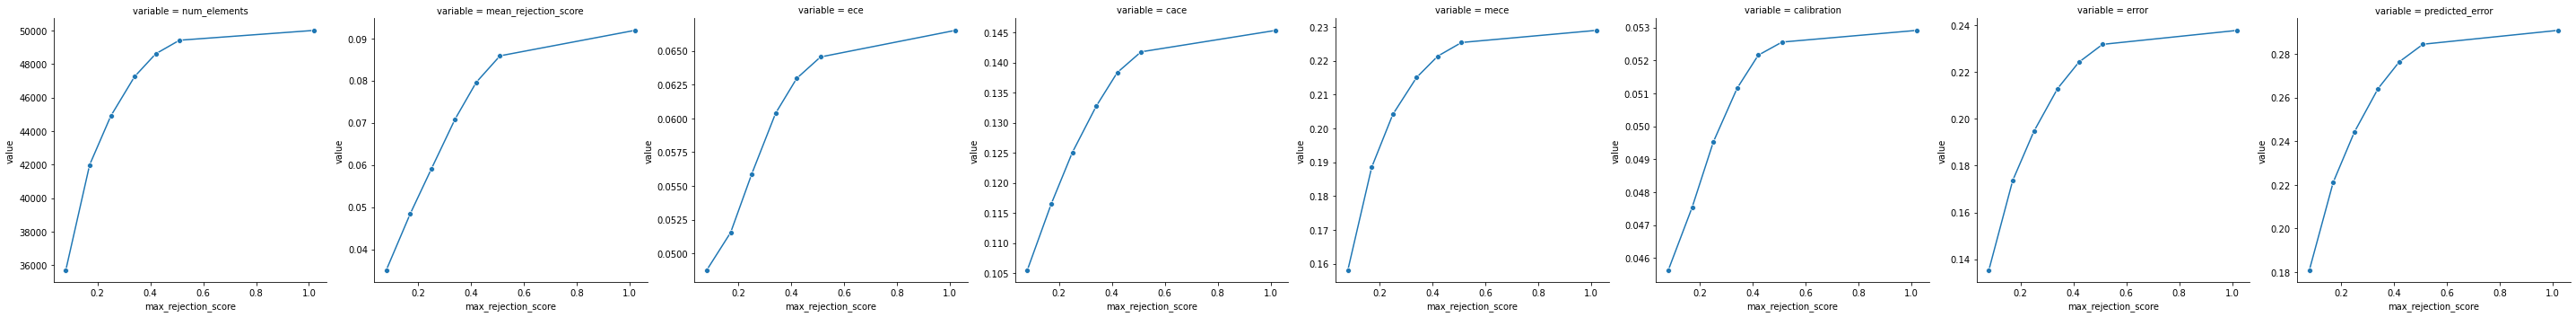

In [128]:
dfm = pd.melt(df, id_vars="max_rejection_score")

sns.relplot(data=dfm, x="max_rejection_score", y="value", col="variable", marker="o", kind="line", aspect=1, facet_kws=dict(sharey=False))


0.0 0
0.1414285727909633 18243
0.2828571455819266 32464
0.42428571837288986 37626
0.5657142911638532 42106
0.7071428639548165 46290
0.8485714367457797 48912
0.9900000095367432 50000


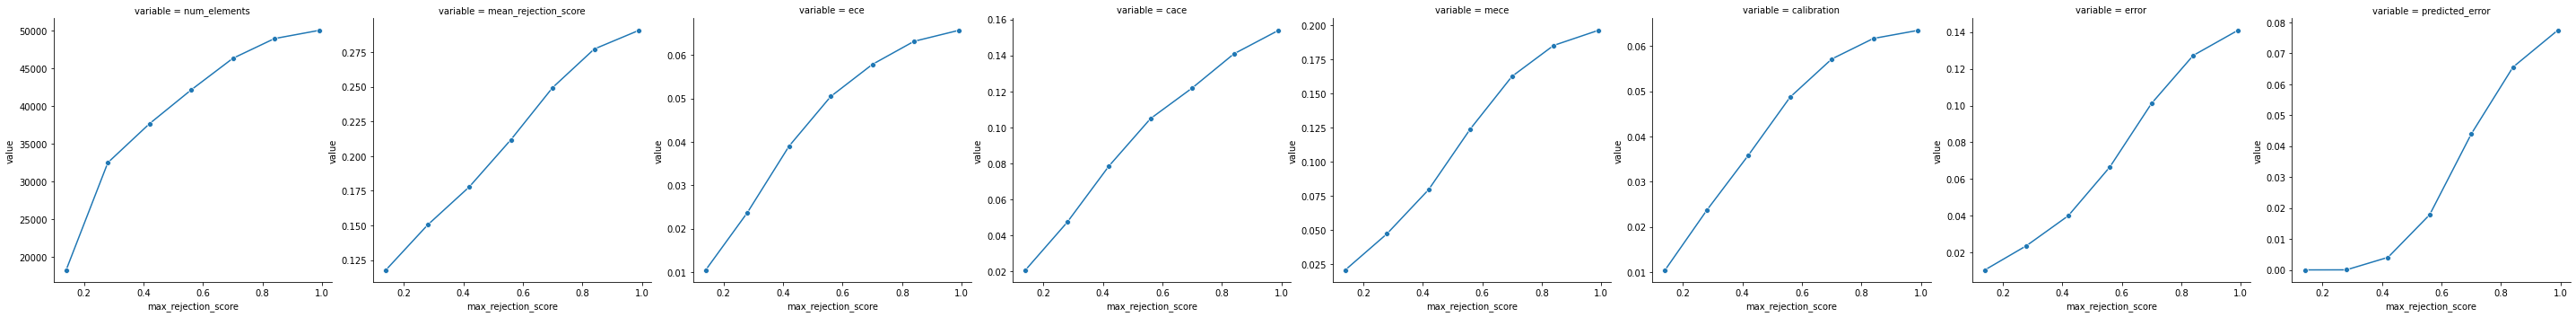

In [129]:
rows = get_rejection_plot_rows(rejection_scores=get_disagreement_rate(mean_probs),
                               max_score=None,
                               num_bins=8, 
                               probs=top_probs,
                               labels=labels)

df=pd.DataFrame.from_dict(rows)
df.drop_duplicates(inplace=True)

dfm = pd.melt(df, id_vars="max_rejection_score")

sns.relplot(data=dfm, x="max_rejection_score", y="value", col="variable", marker="o", kind="line", aspect=1, facet_kws=dict(sharey=False))

df.to_csv(f"{dataset_name}_top_disrate.csv", index=False)

In [130]:
rows = get_rejection_plot_rows(rejection_scores=info_gain(ensemble_probs).numpy(),
                               max_score=0.6,
                               num_bins=8, 
                               probs=top_probs,
                               labels=labels)

df=pd.DataFrame.from_dict(rows)
df.drop_duplicates(inplace=True)

df.to_csv(f"{dataset_name}_top_infogain.csv", index=False)



0.0 0
0.08571428571428572 35715
0.17142857142857143 41981
0.2571428571428571 44892
0.34285714285714286 47243
0.4285714285714286 48602
0.5142857142857142 49413
0.6 50000
